# Forecasting the Neighborhood Change and Detecting Gentrification with Yelp Data

**Data Source**
<br>
Rent data - median studio price by zipcode *downloaded from zillow 
<br>
Yelp data - Yelp API

## Visualising the changes in NYC neighborhoods 
#### - from 2011/11 to 2018/08 - 

In [1]:
# importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
from pyproj import Proj, transform
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import sklearn.linear_model as linreg
from sklearn.metrics import accuracy_score
import seaborn as sns
import datetime
import ast
import statsmodels.formula.api as smf
from sklearn.linear_model import Lasso, Ridge
from scipy import stats
from bokeh.layouts import column, row, widgetbox
from bokeh.models import CustomJS, Slider, Toggle
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, LogTicker, ColorBar
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import push_notebook, output_notebook
from ipywidgets import *
import ipywidgets as widgets
from shapely.geometry import Point, Polygon,MultiPoint, MultiPolygon
warnings.filterwarnings("ignore")
# %matplotlib inline

In [7]:
# calculate statistics
ny_rent_studio = pd.read_csv('csv/EDA/ny_rent_studio.csv', index_col = 0)  # import csv
mean_rent = ny_rent_studio['%_increase'].mean() # find the mean % increase of rent in NYC area
# print('''Average rent increase in Manhattan, Queens, Brooklyn, and Bronx from Nov. 2011 to Aug. 2018 is {:.2f}%'''.format(mean_rent))

## find out how many % of NYC neighborhoods have experienced above mean rent increase
# print(len(ny_rent_studio[ny_rent_studio['%_increase']>mean_rent])/len(ny_rent_studio[~ny_rent_studio['%_increase'].isnull()]))
# len(ny_rent_studio[ny_rent_studio['%_increase']<mean_rent])/len(ny_rent_studio[~ny_rent_studio['%_increase'].isnull()])

- Median studio rent in Manhattan, Queens, Brooklyn, and Bronx has increased by **21.04%** in average since Nov. 2011 to Aug. 2018 
<br>
- Roughly **38.71%** of NYC neighborhood (zipcode level) have experienced above mean ( > 21.04%) rent increase

In [9]:
# import csv files for mapping
ny_qn_bk_studio_df = pd.read_csv('csv/EDA/ny_qn_bk_studio_df_bokeh.csv', index_col = 0)
shape_fiona = gpd.read_file('new.shp') # shape file
# clean up the files
shape_fiona_for_plot = shape_fiona[['ZIPCODE', 'geometry']]
shape_fiona_for_plot.columns =  ['RegionName', 'geometry']
shape_fiona_for_plot.RegionName = shape_fiona_for_plot.RegionName.astype('int')

In [10]:
# create list of lists for mapping (x = latitude, y = longitude)
district_zipcode = shape_fiona_for_plot.RegionName
district_x = [ [list(shape_fiona_for_plot.geometry[i].exterior.coords)[j][0]
              for j in range(0,len(list(shape_fiona_for_plot.geometry[i].exterior.coords)))]
              for i in range(0,len(shape_fiona_for_plot))]
district_y = [ [list(shape_fiona_for_plot.geometry[i].exterior.coords)[j][1]
                for j in range(0,len(list(shape_fiona_for_plot.geometry[i].exterior.coords)))]
              for i in range(0,len(shape_fiona_for_plot))]

# create rent dictionary for mapping (will be used to update the color of polygons)
year = ny_qn_bk_studio_df.columns[7:89]
rent_list = [ny_qn_bk_studio_df[year_] for year_ in year]
rent_dict = dict(zip(year,rent_list))
data = dict(x=district_x, y=district_y, name=district_zipcode,
            rate=rent_list[0], **rent_dict)
source = ColumnDataSource(data)

In [12]:
output_notebook()

custom_colors = ['#f2f2f2', '#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26']
color_mapper = LogColorMapper(palette=custom_colors)  

TOOLS = "pan,wheel_zoom,reset,hover,save"
p = figure(
    title="Median Rental Prices - Studio Apartments", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p.grid.grid_line_color = None
p.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.8, line_color="black", line_width=0.3)

color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p.add_layout(color_bar, 'right')

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("zipcode", "@name"),("rent ($)", "@rate"),("(Long, Lat)", "($x, $y)")]
# show(p, notebook_handle = True)

# w = widgets.SelectionSlider(options=year,value=year[0],disabled=False,continuous_update=False,
#                                                orientation='horizontal',readout=True)
def update(year_month):
    source.data['rate'] = source.data[year_month]
    show(p, notebook_handle=True)
    push_notebook()
    
interact(update, year_month = ['2011-11','2014-11','2016-11', '2018-08'])

Loading BokehJS ...

interactive(children=(Dropdown(description='year_month', options=('2011-11', '2014-11', '2016-11', '2018-08'),…

<function __main__.update(year_month)>

In [16]:
# list top 11 neighborhoods with the fastest rent increase
sorted_rent_increase = ny_rent_studio.sort_values(['%_increase'], ascending = False)
sorted_rent_increase_top_10 = sorted_rent_increase.loc[:10]
region_name_top_10 = sorted_rent_increase_top_10.loc[:,'RegionName':'CountyName']
increase_top_10 = sorted_rent_increase_top_10.loc[:,'2018-08':'%_increase']
sorted_rent_top_10 = pd.concat([region_name_top_10, increase_top_10], axis = 1)
sorted_rent_top_10 = sorted_rent_top_10.reset_index(drop = True)
sorted_rent_top_10 = sorted_rent_top_10.loc[:10]
sorted_rent_top_10['neighborhood'] = ['Flushing', 'Forest Hills', 'Bushwick', 'Rego Park', 'Elmhurst','Midtown East', 'Upper West Side', 'Meatpacking', 'Battery Park', 'City Hall', 'Williamsburg']
sorted_rent_top_10 = sorted_rent_top_10.drop(['City', 'Metro', 'State'], axis = 1)
sorted_rent_top_10.columns = ['zipcode', 'Borough','Rent 2018/08', '%_increase since 2011/11', 'neighborhood']
sorted_rent_top_10["%_increase since 2011/11"] = sorted_rent_top_10["%_increase since 2011/11"].round(2)
sorted_rent_top_10 = sorted_rent_top_10.replace('New York', "Manhattan")
sorted_rent_top_10 = sorted_rent_top_10.replace('Kings', "Brooklyn")
sorted_rent_top_10 = sorted_rent_top_10.drop(['zipcode'], axis = 1)

# list bottom 11 neighborhoods with the fastest rent increase
sorted_rent_increase_asc = ny_rent_studio.sort_values(['%_increase'], ascending = True)
sorted_rent_increase_asc = sorted_rent_increase_asc.reset_index(drop = True)
sorted_rent_increase_asc_top_10 = sorted_rent_increase_asc.loc[:10]
region_name_bottom_10 = sorted_rent_increase_asc_top_10.loc[:,'RegionName':'CountyName']
increase_bottom_10 = sorted_rent_increase_asc_top_10.loc[:,'2018-08':'%_increase']
sorted_rent_bottom_10 = pd.concat([region_name_bottom_10, increase_bottom_10], axis = 1)
sorted_rent_bottom_10['neighborhood'] = ['Midtown West', 'Upper East Side', 'East Harlem', 'East Village', 'Yorkville','Lenox Hill', 'Yorkville', 'Upper West Side', 'Murray Hill','Upper West Side','Yorkville'  ]
sorted_rent_bottom_10 = sorted_rent_bottom_10.drop(['City', 'Metro', 'State'], axis = 1)
sorted_rent_bottom_10.columns = ['zipcode', 'Borough','Rent 2018/08', '%_increase since 2011/11', 'neighborhood']
sorted_rent_bottom_10["%_increase since 2011/11"] = sorted_rent_bottom_10["%_increase since 2011/11"].round(2)
sorted_rent_bottom_10 = sorted_rent_bottom_10.replace('New York', "Manhattan")
sorted_rent_bottom_10 = sorted_rent_bottom_10.drop(['zipcode'], axis = 1)

In [14]:
def update_df(select = 'Neighborhoods with the Fastest Rent Increase'):
    if select == 'Neighborhoods with the Fastest Rent Increase':
        display(sorted_rent_top_10)
    if select == 'Neighborhoods with the Slowest Rent Increase':
        display(sorted_rent_bottom_10)
        
int_widget = interactive(update_df, select= ['Neighborhoods with the Fastest Rent Increase','Neighborhoods with the Slowest Rent Increase'])
int_widget.children[0].layout = Layout(width='450px')
display(int_widget)

interactive(children=(Dropdown(description='select', layout=Layout(width='450px'), options=('Neighborhoods wit…

In [115]:
yelp_williamsburg_one_hot_cumsum = pd.read_csv('csv/EDA/yelp_williamsburg_one_hot_cumsum.csv', index_col = 0)
yelp_bushwick_one_hot_cumsum = pd.read_csv('csv/EDA/yelp_bushwick_one_hot_cumsum.csv', index_col = 0)
yelp_east_harlem_one_hot_cumsum = pd.read_csv('csv/EDA/yelp_east_harlem_one_hot_cumsum.csv', index_col = 0)
yelp_chelsea_clinton_one_hot_cumsum = pd.read_csv('csv/EDA/yelp_chelsea_clinton_one_hot_cumsum.csv', index_col = 0)

yelp_cumsum_rent_williamsburg_df = pd.read_csv('csv/yelp_cumsum_rent_williamsburg.csv', index_col = ['Unnamed: 0'])
yelp_cumsum_rent_williamsburg_df.index = pd.to_datetime(yelp_cumsum_rent_williamsburg_df.index)
yelp_cumsum_rent_east_harlem_df = pd.read_csv('csv/yelp_cumsum_rent_east_harlem.csv', index_col = ['Unnamed: 0'])
yelp_cumsum_rent_east_harlem_df.index = pd.to_datetime(yelp_cumsum_rent_east_harlem_df.index)
yelp_cumsum_rent_bushwick_df = pd.read_csv('csv/yelp_cumsum_rent_bushwick.csv', index_col = ['Unnamed: 0'])
yelp_cumsum_rent_bushwick_df.index = pd.to_datetime(yelp_cumsum_rent_bushwick_df.index)

## Business Changes in the Areas with Fastest and Slowest Rent Increase

In [350]:
yelp_williamsburg_one_hot_cumsum_all_buss = yelp_williamsburg_one_hot_cumsum.sum(axis = 1)
yelp_bushwick_one_hot_cumsum_all_buss = yelp_bushwick_one_hot_cumsum.sum(axis = 1)
yelp_east_harlem_one_hot_cumsum_all_buss = yelp_east_harlem_one_hot_cumsum.sum(axis = 1)
yelp_chelsea_clinton_one_hot_cumsum_all_buss = yelp_chelsea_clinton_one_hot_cumsum.sum(axis = 1)
yelp_williamsburg_all_buss_perc_change = yelp_williamsburg_one_hot_cumsum_all_buss.apply(lambda x: 100*(x - yelp_williamsburg_one_hot_cumsum_all_buss.iloc[0])/yelp_williamsburg_one_hot_cumsum_all_buss.iloc[0])
yelp_bushwick_all_buss_perc_change = yelp_bushwick_one_hot_cumsum_all_buss.apply(lambda x: 100*(x - yelp_bushwick_one_hot_cumsum_all_buss.iloc[0])/yelp_bushwick_one_hot_cumsum_all_buss.iloc[0])
yelp_east_harlem_all_buss_perc_change = yelp_east_harlem_one_hot_cumsum_all_buss.apply(lambda x: 100*(x - yelp_east_harlem_one_hot_cumsum_all_buss.iloc[0])/yelp_east_harlem_one_hot_cumsum_all_buss.iloc[0])
yelp_chelsea_clinton_all_buss_perc_change = yelp_chelsea_clinton_one_hot_cumsum_all_buss.apply(lambda x: 100*(x - yelp_chelsea_clinton_one_hot_cumsum_all_buss.iloc[0])/yelp_chelsea_clinton_one_hot_cumsum_all_buss.iloc[0])

In [351]:
# cafe
# williamsburg
cafe_williamsburg = yelp_williamsburg_one_hot_cumsum['category_coffee']
# bushwick
cafe_bushwick = yelp_bushwick_one_hot_cumsum['category_coffee']
#east harlem 
cafe_east_harlem = yelp_east_harlem_one_hot_cumsum['category_coffee']
#chelsea clinton 
cafe_chelsea_clinton = yelp_chelsea_clinton_one_hot_cumsum['category_coffee']

# bars
# williamsburg
bars_williamsburg = yelp_williamsburg_one_hot_cumsum['category_bars']
# bushwick
bars_bushwick = yelp_bushwick_one_hot_cumsum['category_bars']
bars_bushwick = bars_bushwick[bars_bushwick.index >= '2012-05-01']
#east harlem 
bars_east_harlem = yelp_east_harlem_one_hot_cumsum['category_bars']
#chelsea clinton
bars_chelsea_clinton = yelp_chelsea_clinton_one_hot_cumsum['category_bars']

In [352]:
#cafes
yelp_williamsburg_cafe_perc_change = cafe_williamsburg.apply(lambda x: 100*(x - cafe_williamsburg.iloc[0])/cafe_williamsburg.iloc[0])
yelp_bushwick_cafe_perc_change = cafe_bushwick.apply(lambda x: 100*(x - cafe_bushwick.iloc[0])/cafe_bushwick.iloc[0])
yelp_east_harlem_cafe_perc_change = cafe_east_harlem.apply(lambda x: 100*(x - cafe_east_harlem.iloc[0])/cafe_east_harlem.iloc[0])
yelp_chelsea_clinton_cafe_perc_change = cafe_chelsea_clinton.apply(lambda x: 100*(x - cafe_chelsea_clinton.iloc[0])/cafe_chelsea_clinton.iloc[0])
#bars
yelp_williamsburg_bars_perc_change = bars_williamsburg.apply(lambda x: 100*(x - bars_williamsburg.iloc[0])/bars_williamsburg.iloc[0])
yelp_bushwick_bars_perc_change = bars_bushwick.apply(lambda x: 100*(x - bars_bushwick.iloc[0])/bars_bushwick.iloc[0])
yelp_east_harlem_bars_perc_change = bars_east_harlem.apply(lambda x: 100*(x - bars_east_harlem.iloc[0])/bars_east_harlem.iloc[0])
yelp_chelsea_clinton_bars_perc_change = bars_chelsea_clinton.apply(lambda x: 100*(x - bars_chelsea_clinton.iloc[0])/bars_chelsea_clinton.iloc[0])

*oldest review on Yelp was used to define opening date of business; hence number of new businesses means number of businesses that have received first reviews during the month*

Figures on the right show the cumulative growth (= percentage increase) of new businesses by month in the neighborhoods with fast rent increase (Williamsburg and Bushwick) and slow rent increase (East Harlem and Chelsea/Clinton). <br>
- businesses seem to grow faster in the areas where the rent has been growing rapidly - the rent has increased by **39.37%** (3rd in the NYC area) in Bushwick and **24.00%** (11th) in Williamsburg, while it was **5.48%** (3rd from the bottom) in East Harlem, and was **13.04%** in Chelsea/Clinton

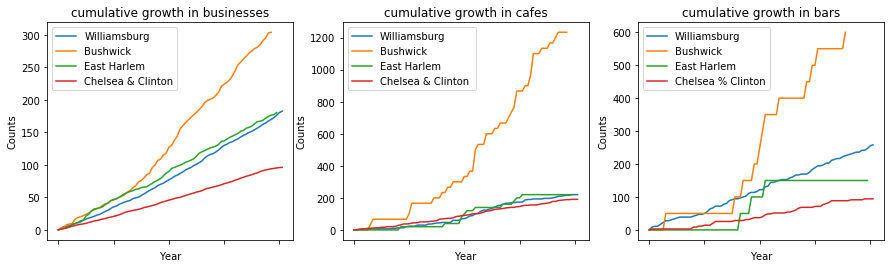

In [361]:
%matplotlib inline
plt.figure(figsize = (15,4))
plt.subplot(131)
yelp_williamsburg_all_buss_perc_change.plot()
yelp_bushwick_all_buss_perc_change.plot()
yelp_east_harlem_all_buss_perc_change.plot()
yelp_chelsea_clinton_all_buss_perc_change.plot()
plt.legend(['Williamsburg', 'Bushwick', "East Harlem", "Chelsea & Clinton"])
plt.xlabel('Year')
plt.ylabel('Counts')
plt.title('cumulative growth in businesses')

plt.subplot(132)
yelp_williamsburg_cafe_perc_change.plot()
yelp_bushwick_cafe_perc_change.plot()
yelp_east_harlem_cafe_perc_change.plot()
yelp_chelsea_clinton_cafe_perc_change.plot()
plt.legend(['Williamsburg', 'Bushwick', "East Harlem", "Chelsea & Clinton "])
plt.xlabel('Year')
plt.ylabel('Counts')
plt.title('cumulative growth in cafes')

plt.subplot(133)
yelp_williamsburg_bars_perc_change.plot()
yelp_bushwick_bars_perc_change.plot()
yelp_east_harlem_bars_perc_change.plot()
yelp_chelsea_clinton_bars_perc_change.plot()
plt.legend(['Williamsburg', 'Bushwick', "East Harlem", "Chelsea % Clinton"])
plt.title('cumulative growth in bars')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.show()

In [3]:
yelp_williamsburg_one_hot_cumsum_top10 = pd.read_csv('csv/linear_regression/yelp_williamsburg_one_hot_cumsum_top10.csv', index_col = 0)
yelp_bushwick_one_hot_cumsum_top10 = pd.read_csv('csv/linear_regression/yelp_bushwick_one_hot_cumsum_top10.csv', index_col = 0)

In [121]:
yelp_williamsburg_one_hot_cumsum_top10.index = pd.to_datetime(yelp_williamsburg_one_hot_cumsum_top10.index)
yelp_bushwick_one_hot_cumsum_top10.index = pd.to_datetime(yelp_bushwick_one_hot_cumsum_top10.index)

## Cases of the Areas with the Fast Rent Growth - Williamsburg and Bushwick

### Is there any correlation between business growth and rent increase??
- we just saw that both rent and businesses have been growing in these areas - does increase in rent and business actually correlate to each other?

<IPython.core.display.Javascript object>


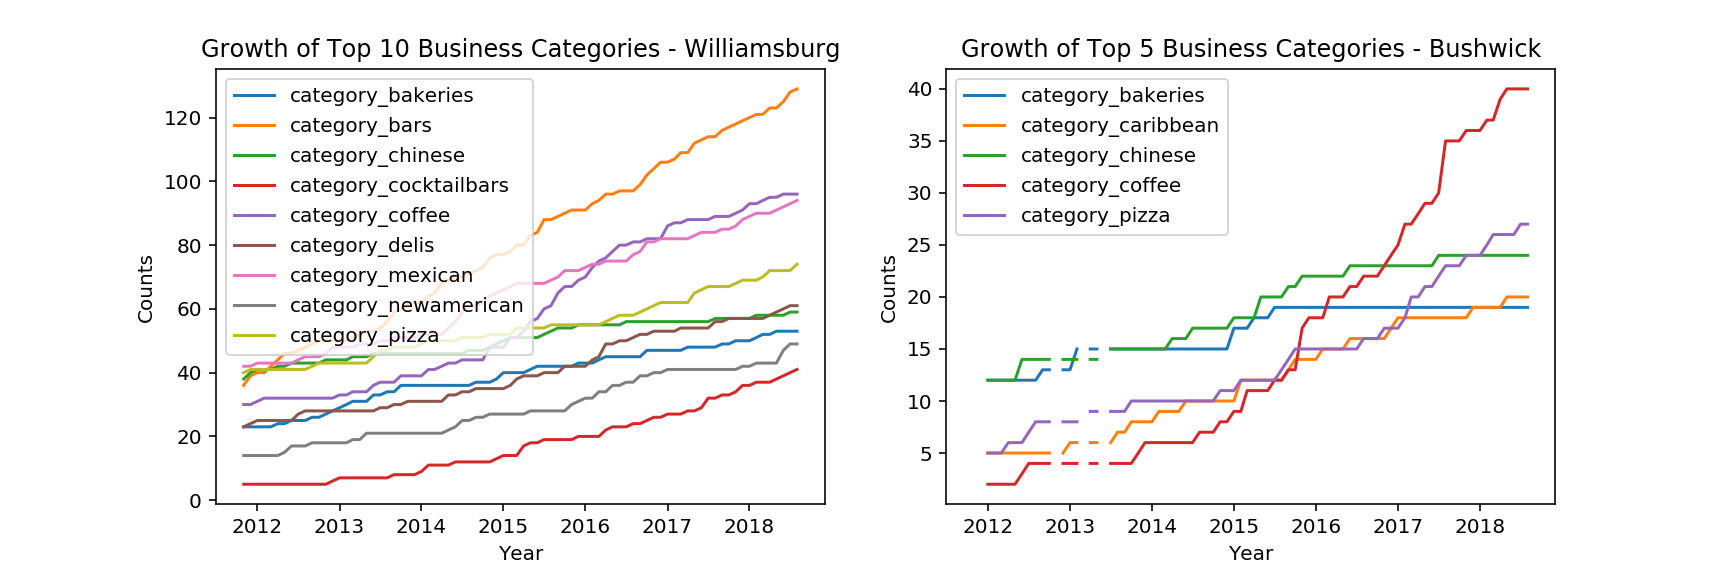

In [131]:
%matplotlib notebook
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.plot(yelp_williamsburg_one_hot_cumsum_top10)
plt.title('Growth of Top 10 Business Categories - Williamsburg')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend(yelp_williamsburg_one_hot_cumsum_top10.columns)
plt.show()

plt.subplot(122)
plt.plot(yelp_bushwick_one_hot_cumsum_top10)
plt.title('Growth of Top 5 Business Categories - Bushwick')
plt.xticks()
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend(yelp_bushwick_one_hot_cumsum_top10.columns)
plt.show()

Figures on the left show top 10 and 5 growing businesses in Williamsburg and Bushwick (cumulative sum over time). Bars in Williamsburg and Cafes in Bushwick seem to lead the others.
<br>
**Can we use this to predict the rent...?**

In [132]:
# Williamsburg
yelp_williamsburg_cumsum_perc_inc_df = pd.read_csv('csv/yelp_cumsum_percent_inc_rent_williamsburg.csv', index_col = ['Unnamed: 0'])
yelp_williamsburg_cumsum_perc_inc_df.index = pd.to_datetime(yelp_williamsburg_cumsum_perc_inc_df.index)
# Bushwick
yelp_bushwick_cumsum_perc_inc_df = pd.read_csv('csv/yelp_cumsum_percent_inc_rent_bushwick.csv', index_col = ['Unnamed: 0'])
yelp_bushwick_cumsum_perc_inc_df.index = pd.to_datetime(yelp_bushwick_cumsum_perc_inc_df.index)

In [133]:
yelp_williamsburg_cumsum_perc_inc_df["%increase_rent_month_later"] = yelp_williamsburg_cumsum_perc_inc_df['%increase_rent'].shift(1)
yelp_williamsburg_cumsum_perc_inc_df["%increase_rent_2_month_later"] = yelp_williamsburg_cumsum_perc_inc_df['%increase_rent'].shift(2)

In [196]:
# yelp_bushwick_cumsum_perc_inc_df=yelp_bushwick_cumsum_perc_inc_df.rename(columns = {'rent':'%increase_rent'})

In [197]:
yelp_bushwick_cumsum_perc_inc_df["%increase_rent_month_later"] = yelp_bushwick_cumsum_perc_inc_df['%increase_rent'].shift(1)
yelp_bushwick_cumsum_perc_inc_df["%increase_rent_2_month_later"] = yelp_bushwick_cumsum_perc_inc_df['%increase_rent'].shift(2)

In [134]:
# pearson's corr for percent increase in each business vs. percent increase in rent
pearsons_corr_perc_inc  = yelp_williamsburg_cumsum_perc_inc_df.corr()
corr_to_rent_perc_inc = pearsons_corr_perc_inc['%increase_rent']
corr_to_rent_perc_inc = corr_to_rent_perc_inc.dropna()
corr_to_rent_perc_inc = corr_to_rent_perc_inc.to_frame().transpose()
corr_to_rent_perc_inc = corr_to_rent_perc_inc.loc[:, :'category_wine_bars']

# pearson's corr for percent increase in each business vs. percent increase in rent a month later
corr_to_rent_perc_inc_month = pearsons_corr_perc_inc["%increase_rent_month_later"]
corr_to_rent_perc_inc_month = corr_to_rent_perc_inc_month.dropna()
corr_to_rent_perc_inc_month = corr_to_rent_perc_inc_month.to_frame().transpose()
corr_to_rent_perc_inc_month = corr_to_rent_perc_inc_month.loc[:, :'category_wine_bars']

# pearson's corr for percent increase in each business vs. percent increase in rent a month later
corr_to_rent_perc_inc_2_month = pearsons_corr_perc_inc["%increase_rent_2_month_later"]
corr_to_rent_perc_inc_2_month = corr_to_rent_perc_inc_2_month.dropna()
corr_to_rent_perc_inc_2_month = corr_to_rent_perc_inc_2_month.to_frame().transpose()
corr_to_rent_perc_inc_2_month = corr_to_rent_perc_inc_2_month.loc[:, :'category_wine_bars']

In [209]:
# pearson's corr for percent increase in each business vs. percent increase in rent
pearsons_corr_perc_inc_bushwick  = yelp_bushwick_cumsum_perc_inc_df.corr()
corr_to_rent_perc_inc_bushwick = pearsons_corr_perc_inc_bushwick['%increase_rent']
corr_to_rent_perc_inc_bushwick = corr_to_rent_perc_inc_bushwick.dropna()
corr_to_rent_perc_inc_bushwick = corr_to_rent_perc_inc_bushwick.to_frame().transpose()
corr_to_rent_perc_inc_bushwick = corr_to_rent_perc_inc_bushwick.loc[:, :'category_wine_bars']

# pearson's corr for percent increase in each business vs. percent increase in rent a month later
corr_to_rent_perc_inc_month_bushwick = pearsons_corr_perc_inc_bushwick["%increase_rent_month_later"]
corr_to_rent_perc_inc_month_bushwick = corr_to_rent_perc_inc_month_bushwick.dropna()
corr_to_rent_perc_inc_month_bushwick = corr_to_rent_perc_inc_month_bushwick.to_frame().transpose()
corr_to_rent_perc_inc_month_bushwick = corr_to_rent_perc_inc_month_bushwick.loc[:, :'category_wine_bars']

# pearson's corr for percent increase in each business vs. percent increase in rent a month later
corr_to_rent_perc_inc_2_month_bushwick = pearsons_corr_perc_inc_bushwick["%increase_rent_2_month_later"]
corr_to_rent_perc_inc_2_month_bushwick = corr_to_rent_perc_inc_2_month_bushwick.dropna()
corr_to_rent_perc_inc_2_month_bushwick = corr_to_rent_perc_inc_2_month_bushwick.to_frame().transpose()
corr_to_rent_perc_inc_2_month_bushwick = corr_to_rent_perc_inc_2_month_bushwick.loc[:, :'category_wine_bars']

In [143]:
corr_to_rent_perc_inc = corr_to_rent_perc_inc[list(yelp_williamsburg_one_hot_cumsum_top10.columns)]
corr_to_rent_perc_inc_month = corr_to_rent_perc_inc_month[list(yelp_williamsburg_one_hot_cumsum_top10.columns)]
corr_to_rent_perc_inc_2_month = corr_to_rent_perc_inc_2_month[list(yelp_williamsburg_one_hot_cumsum_top10.columns)]

In [210]:
corr_to_rent_perc_inc_bushwick = corr_to_rent_perc_inc_bushwick[list(yelp_bushwick_one_hot_cumsum_top10.columns)]
corr_to_rent_perc_inc_month_bushwick = corr_to_rent_perc_inc_month_bushwick[list(yelp_bushwick_one_hot_cumsum_top10.columns)]
corr_to_rent_perc_inc_2_month_bushwick = corr_to_rent_perc_inc_2_month_bushwick[list(yelp_bushwick_one_hot_cumsum_top10.columns)]

### Williamsburg

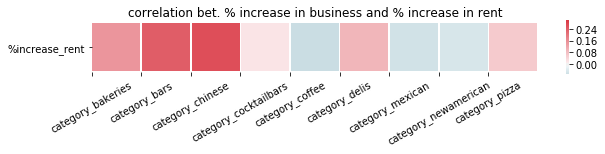

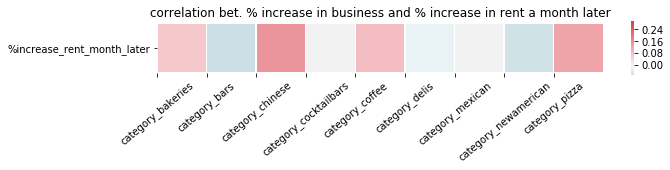

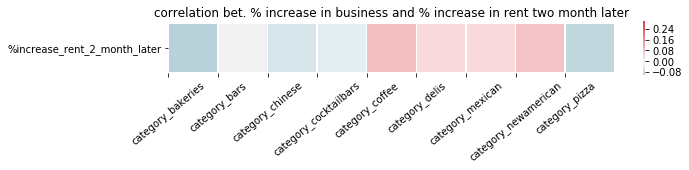

In [362]:
%matplotlib inline
f, ax = plt.subplots(figsize=(10, 2))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = plt.axes()
sns.heatmap(corr_to_rent_perc_inc,cmap=cmap,vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax)
ax.set_title('correlation bet. % increase in business and % increase in rent')
plt.xticks(np.arange(corr_to_rent_perc_inc.shape[1])[:10], corr_to_rent_perc_inc.columns, rotation = 30, ha = 'center')
plt.yticks(rotation = 0)
plt.show()

f, ax = plt.subplots(figsize=(10, 2))
labels = [''.join(wrap(corr_to_rent_perc_inc_2_month.index[0], 5))]
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = plt.axes()
sns.heatmap(corr_to_rent_perc_inc_month,cmap=cmap,vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax)
ax.set_title('correlation bet. % increase in business and % increase in rent a month later')
plt.xticks(np.arange(corr_to_rent_perc_inc.shape[1])[:10], corr_to_rent_perc_inc_month.columns, rotation = 40, ha = 'center')
plt.yticks(rotation = 0)
plt.show()

f, ax = plt.subplots(figsize=(10, 2))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = plt.axes()
sns.heatmap(corr_to_rent_perc_inc_2_month,cmap=cmap,vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax)
ax.set_title('correlation bet. % increase in business and % increase in rent two month later')
plt.xticks(np.arange(corr_to_rent_perc_inc.shape[1])[:10], corr_to_rent_perc_inc_2_month.columns, rotation = 40, ha = 'center')
plt.yticks(rotation = 0)
plt.show()

In [370]:
# yelp_cumsum_rent_williamsburg_df[yelp_cumsum_rent_williamsburg_df.rent>2800]

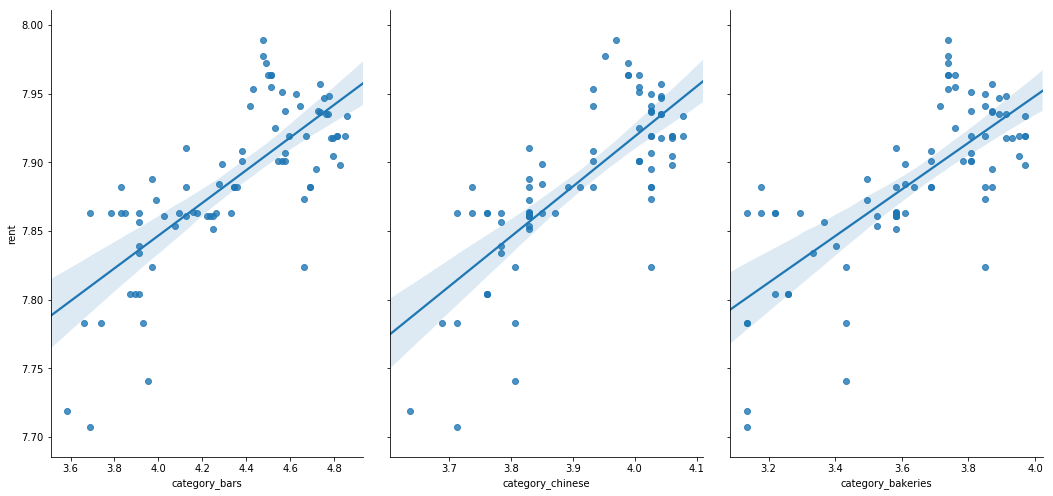

In [284]:
# log-transform
log_yelp_cumsum_rent_williamsburg_df = np.log(yelp_cumsum_rent_williamsburg_df)
sns.pairplot(log_yelp_cumsum_rent_williamsburg_df, x_vars=['category_bars','category_chinese','category_bakeries'], y_vars='rent', size=7, aspect=0.7, kind='reg')
plt.show()

|          |rent vs. bars |rent vs. chinese rest.|rent vs. bakeries | 
|----------|:-------------|:---------------------|:----------------:|
|p-value   |1.33e-15      |1.46e-16              |2.95e-15          |
|r-squared |55.20%        |57.59%                | 54.31%           |

In [372]:
lm1_multivariable = smf.ols(formula='rent ~ category_bars + category_chinese + category_bakeries', data=log_yelp_cumsum_rent_williamsburg_df).fit()
# print the coefficients
# lm1_multivariable.params

p-values are all far less than 0.05.
- we can reject the null hypothesis that there is no relationship between these parameters and rent
- we can conclude that there is some correlation between the # of bars/chinese restaurants/bakeries and studio rent <br>

Looking at r-squares, the chinese restaurant model performs the best

**Would they perform better together?**

|                    |rent vs. bars + Chinese rest. + bakeries | 
|--------------------|:----------------------------------------|
|p-value - bars      |0.658                                    |
|p-value - Chinese   |0.041                                    |
|p-value - bakeries  |0.645                                    |
|r-squared           |57.70%                                   |

In [404]:
# print('Would they perform better together?')
# lm1_multivariable.summary()

**Or could we predict the future?**

In [400]:
lm1_multivariable_two_month = smf.ols(formula='two_month_pred ~ category_coffee + category_newamerican', data=log_yelp_cumsum_rent_williamsburg_df).fit()
# print the coefficients
# lm1_multivariable.params

|                    |rent vs. cafes and New American (opened 2 month ago) | 
|--------------------|:----------------------------------------|
|p-value - cafes      |0.023                                    |
|p-value - New American   |0.657                                   |
|r-squared           |51.20%                                   |

In [405]:
# lm1_multivariable_two_month.summary()

In [407]:
# log_yelp_cumsum_rent_williamsburg_df = np.log(yelp_cumsum_rent_williamsburg_df)
# sns.pairplot(log_yelp_cumsum_rent_williamsburg_df, x_vars=['category_coffee'], y_vars='two_month_pred', size=7, aspect=0.7, kind='reg')
# plt.show()

In [406]:
# # ### STATSMODELS FOR CAFE COUNTS###
# lm1_cafe_2_month = smf.ols(formula='two_month_pred ~ category_coffee', data=log_yelp_cumsum_rent_williamsburg_df).fit()
# # print the coefficients
# print('< number of cafes vs. rent >')
# print(lm1_cafe_2_month.params)
# print('Result - rent vs. number of cafes')
# display(lm1_cafe_2_month.conf_int())
# # null hypothesis - there is no relationship bet. # of bars and rent
# print('p-values: ')
# print(lm1_cafe_2_month.pvalues)
# print('r-squared: {:.2f}%'.format(100*lm1_cafe_2_month.rsquared))

In [367]:
# ### STATSMODELS for BAR COUNTS### 
# # create a fitted model
# lm1 = smf.ols(formula='rent ~ category_bars', data=log_yelp_cumsum_rent_williamsburg_df).fit()
# # # print the coefficients
# # print('< number of bars vs. rent >')
# # print(lm1.params)
# display(lm1.conf_int())
# # null hypothesis - there is no relationship bet. # of bars and rent
# print('p-values: ')
# print(lm1.pvalues)
# print('r-squared: {:.2f}%'.format(100*lm1.rsquared))

In [368]:
# # ### STATSMODELS FOR CAFE COUNTS###
# lm1_chinese = smf.ols(formula='rent ~ category_chinese', data=log_yelp_cumsum_rent_williamsburg_df).fit()
# # print the coefficients
# print('< number of cafes vs. rent >')
# print(lm1_chinese.params)
# print('Result - rent vs. number of cafes')
# display(lm1_chinese.conf_int())
# # null hypothesis - there is no relationship bet. # of bars and rent
# print('p-values: ')
# print(lm1_chinese.pvalues)
# print('r-squared: {:.2f}%'.format(100*lm1_chinese.rsquared))

In [369]:
# ### STATSMODELS FOR MEXICAN COUNTS###
# # create a fitted model
# lm1_bakeries = smf.ols(formula='rent ~ category_bakeries', data=log_yelp_cumsum_rent_williamsburg_df).fit()
# # # print the coefficients
# # print('< number of mexican spots vs. rent >')
# # print(lm1_mexican.params)
# # print('Result - rent vs. number of mexican restaurants')
# display(lm1_bakeries.conf_int())
# # null hypothesis - there is no relationship bet. # of bars and rent
# print('p-values: ')
# print(lm1_bakeries.pvalues)
# print('r-squared: {:.2f}%'.format(100*lm1_bakeries.rsquared))

### Bushwick

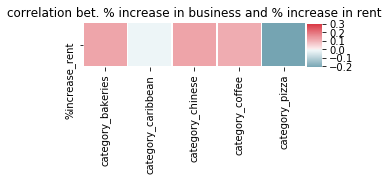

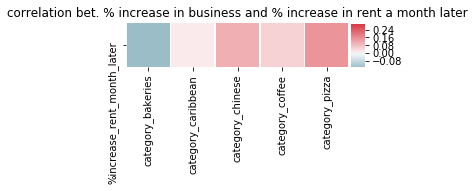

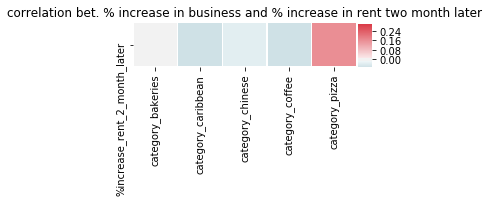

In [282]:
%matplotlib inline
f, ax = plt.subplots(figsize=(4, 3))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = plt.axes()
cbar_ax = f.add_axes([.905, .4, .05, .2])
sns.heatmap(corr_to_rent_perc_inc_bushwick,cbar_ax = cbar_ax, cmap=cmap,vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax)
ax.set_title('correlation bet. % increase in business and % increase in rent')
plt.xticks(np.arange(corr_to_rent_perc_inc_bushwick.shape[1])[:10], corr_to_rent_perc_inc_bushwick.columns, rotation = 30, ha = 'center')
plt.yticks(rotation = 0)
plt.show()

f, ax = plt.subplots(figsize=(4, 3))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = plt.axes()
cbar_ax = f.add_axes([.905, .4, .05, .2])
sns.heatmap(corr_to_rent_perc_inc_month_bushwick,cmap=cmap,vmax=.3, cbar_ax = cbar_ax, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax)
ax.set_title('correlation bet. % increase in business and % increase in rent a month later')
plt.xticks(np.arange(corr_to_rent_perc_inc_month_bushwick.shape[1])[:10], corr_to_rent_perc_inc_month_bushwick.columns, rotation = 30, ha = 'center')
plt.yticks(rotation = 0)
plt.show()

f, ax = plt.subplots(figsize=(4, 3))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = plt.axes()
cbar_ax = f.add_axes([.905, .4, .05, .2])
sns.heatmap(corr_to_rent_perc_inc_2_month_bushwick,cmap=cmap,vmax=.3, cbar_ax = cbar_ax, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax)
ax.set_title('correlation bet. % increase in business and % increase in rent two month later')
plt.xticks(np.arange(corr_to_rent_perc_inc_2_month_bushwick.shape[1])[:10], corr_to_rent_perc_inc_2_month_bushwick.columns, rotation = 30, ha = 'center')
plt.yticks(rotation = 0)
plt.show()

In [412]:
log_yelp_cumsum_rent_bushwick_df = np.log(yelp_cumsum_rent_bushwick_df)

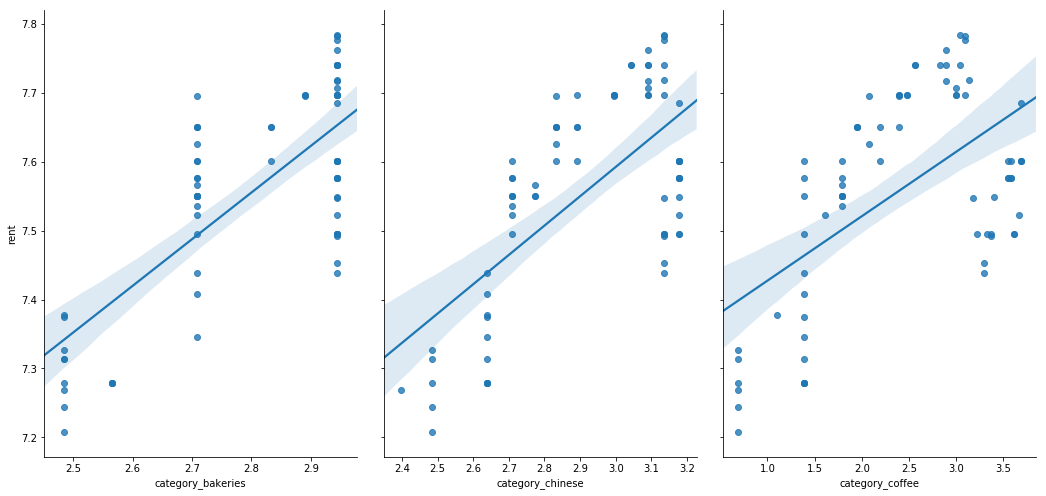

In [422]:
sns.pairplot(log_yelp_cumsum_rent_bushwick_df, x_vars=['category_bakeries','category_chinese','category_coffee'], y_vars='rent', size=7, aspect=0.7, kind='reg')
plt.show()

|          |rent vs. bakeries |rent vs. chinese rest.|rent vs. cafes    | 
|----------|:-----------------|:---------------------|:----------------:|
|p-value   |6.59e-15          |2.55e-11              |2.37e-08          |
|r-squared |55.24%            |44.51%                | 33.81%           |

In [417]:
# ### STATSMODELS for BAR COUNTS### 
# # create a fitted model
# lm1_bushwick_coffee = smf.ols(formula='rent ~ category_coffee', data=log_yelp_cumsum_rent_bushwick_df).fit()
# # print the coefficients
# print('< number of cafes vs. rent >')
# print(lm1_bushwick_coffee.params)
# display(lm1_bushwick_coffee.conf_int())
# # null hypothesis - there is no relationship bet. # of bars and rent
# print('p-values: ')
# print(lm1_bushwick_coffee.pvalues)
# print('r-squared: '+ str(lm1_bushwick_coffee.rsquared))

In [419]:
# ### STATSMODELS for BAR COUNTS### 
# # create a fitted model
# lm1_bushwick_chinese = smf.ols(formula='rent ~ category_chinese', data=log_yelp_cumsum_rent_bushwick_df).fit()
# # print the coefficients
# print('< number of chinese vs. rent >')
# print(lm1_bushwick_chinese.params)
# display(lm1_bushwick_chinese.conf_int())
# # null hypothesis - there is no relationship bet. # of bars and rent
# print('p-values: ')
# print(lm1_bushwick_chinese.pvalues)
# print('r-squared: '+ str(lm1_bushwick_chinese.rsquared))

In [421]:
# ### STATSMODELS for BAR COUNTS### 
# # create a fitted model
# lm1_bushwick_bakeries = smf.ols(formula='rent ~ category_bakeries', data=log_yelp_cumsum_rent_bushwick_df).fit()
# # print the coefficients
# print('< number of bakeries vs. rent >')
# print(lm1_bushwick_bakeries.params)
# display(lm1_bushwick_bakeries.conf_int())
# # null hypothesis - there is no relationship bet. # of bars and rent
# print('p-values: ')
# print(lm1_bushwick_bakeries.pvalues)
# print('r-squared: '+ str(lm1_bushwick_bakeries.rsquared))

## Predict the Future Rent with Time Series Analysis
#### Now that we saw that there are some correlations between business growth and rent increase, can we use time series analysis to predict the future rent?
- as the rent varies area-by-area, I am goint to focus only on Williamsburg
- use number of bars as exogenous parameter of time series

In [437]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [426]:
# yelp_williamsburg_cumsum_perc_inc_df_arimax = yelp_williamsburg_cumsum_perc_inc_df.loc[:,:'%increase_rent']
# rent_williamsburg = yelp_cumsum_rent_williamsburg_df['rent']
yelp_williamsburg_cumsum_df_arimax = pd.concat([yelp_williamsburg_cumsum_perc_inc_df_arimax, rent_williamsburg], axis =1 )

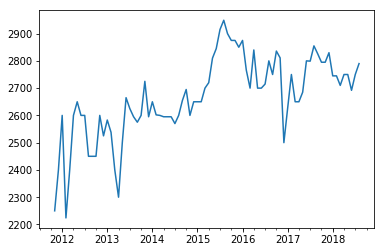

In [429]:
rent_williamsburg.plot()
plt.show()

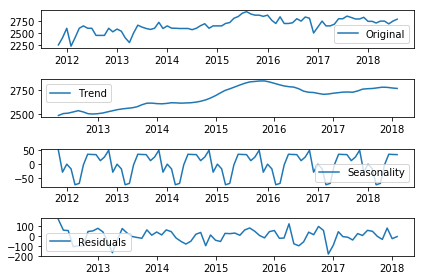

In [431]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_williamsburg = seasonal_decompose(rent_williamsburg)

# Gather the trend, seasonality and noise of decomposed object
trend_williamsburg = decomposition_williamsburg.trend
seasonal_williamsburg = decomposition_williamsburg.seasonal
residual_williamsburg = decomposition_williamsburg.resid

# Plot gathered statistics
# rcParams['figure.figsize'] = 15, 15
plt.subplot(411)
plt.plot(rent_williamsburg, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_williamsburg, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_williamsburg,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_williamsburg, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [433]:
log_yelp_williamsburg_cumsum_df_arimax = np.log(yelp_williamsburg_cumsum_df_arimax['rent'])
log_diff_yelp_williamsburg_cumsum_df_arimax = yelp_williamsburg_cumsum_df_arimax['rent'] - log_yelp_williamsburg_cumsum_df_arimax
rolmean_log = log_yelp_williamsburg_cumsum_df_arimax.rolling(window=12).mean()
rolstd_log = log_yelp_williamsburg_cumsum_df_arimax.rolling(window=12).std()
rent_studio_williamsburg_log_moving_avg_diff = log_yelp_williamsburg_cumsum_df_arimax - rolmean_log

In [438]:
# rent_studio_williamsburg_log_moving_avg_diff = rent_studio_williamsburg_log_moving_avg_diff.dropna()
exog_log = yelp_williamsburg_cumsum_perc_inc_df_arimax['category_bars'][yelp_williamsburg_cumsum_perc_inc_df_arimax['category_bars'].index>='2012-10-01']
model_log = SARIMAX(endog = rent_studio_williamsburg_log_moving_avg_diff, exog = exog_log, order = (1,1,1))
fitted_log = model_log.fit()
pred_in_log = fitted_log.predict()
pred_in_log.name = 'pred_in_log'

In [439]:
pred = fitted_log.get_prediction(start=pd.to_datetime('2017-01'), dynamic=False)
pred_conf = pred.conf_int()

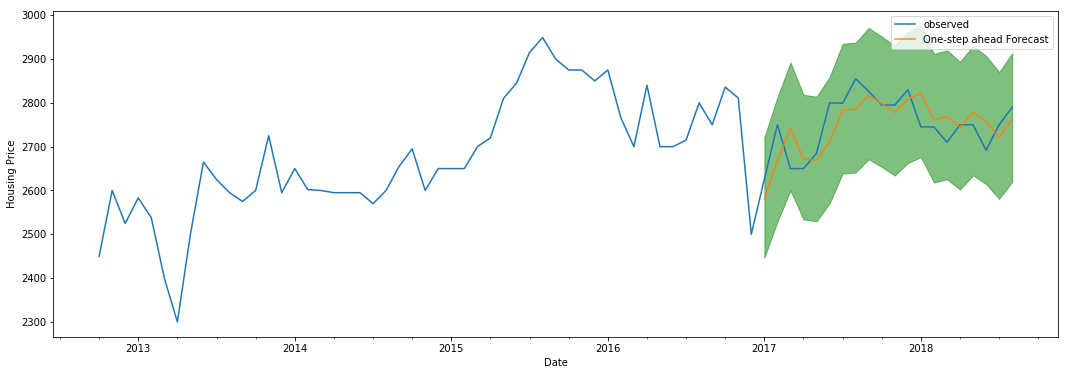

In [442]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 6
#Plot observed values
ax = (np.exp((rent_studio_williamsburg_log_moving_avg_diff+rolmean_log)).plot(label='observed'))

#Plot predicted values
(np.exp((pred.predicted_mean)+rolmean_log)).plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(rolmean_log.index,
                np.exp(pred_conf.iloc[:,0]+rolmean_log),
                np.exp(pred_conf.iloc[:,1]+rolmean_log), color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Housing Price')
plt.legend()

plt.show()

## Detecting Gentrification using Machine Learning Algorithms

#### We've only looked at Williamsburg, and Bushwick, but can we generalize it to the whole NYC area?
- use machine learning algorithm to detect if the area is:<br>
    - **Gentrifying**: the area that was low-income in 1990 and experienced rent growth above the median SBA rent growth between 1990 and 2010-2014<br>
    - **Non-gentrifying**: the areas that started off as low-income in 1990 but experienced more modest growth<br>
    - **Higher-income**: the areas that had higher incomes in 1990.

- for this, some of yelp data are combined with demographic data from 2016 Census

*Source: http://furmancenter.org/files/sotc/Part_1_Gentrification_SOCin2015_9JUNE2016.pdf*
  


In [448]:
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from textwrap import wrap

In [445]:
zipcode_neighborhood_df_test_exc_income = pd.read_csv('zipcode_neighborhood_df_test_exc_income.csv', index_col = 0)

In [446]:
X = zipcode_neighborhood_df_test_exc_income.loc[:,'avg_rating':]
target = zipcode_neighborhood_df_test_exc_income['gentrification_label']
X = X.replace('-', 0)

In [452]:
# # correct the class imbalance
# print(target.value_counts())
# X_resampled, y_resampled = SMOTE().fit_sample(X, target) 
# print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

#### Random Forest Classifier


 Top 10 Features:
("% bachelor's degree or higher", 0.1207)
('% High school graduate (includes equivalency)', 0.082)
('%, 9th to 12th grade, no diploma', 0.0815)
('% Some other race', 0.0762)
("% A Associate's degree", 0.0749)
("% Bachelor's degree", 0.0729)
('%, Less than 9th grade', 0.062)
('% high school graduate or higher', 0.0608)
('% White', 0.0478)
('cafe_count', 0.0456)
Accuracy: 90.71 (+/- 12.46)


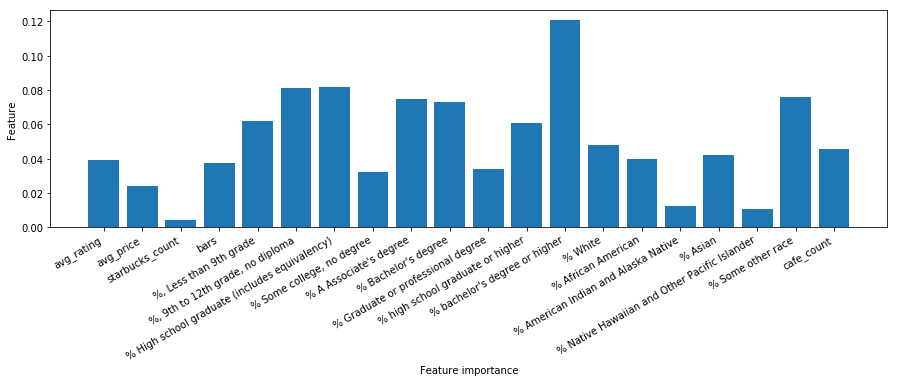

In [451]:
%matplotlib inline
data_train, data_test, target_train, target_test = train_test_split(X_resampled, y_resampled)
forest= RandomForestClassifier(n_estimators= 40, max_depth= 5)
forest.fit(data_train, target_train)
feature_importances = forest.feature_importances_
feature_importance_list = [round(value, 4) for value in feature_importances]

def plot_feature_importances(model, data):
    n_features = data.shape[1]
    plt.figure(figsize=(15,4))
#     labels = [ '\n'.join(wrap(l, 35)) for l in data.columns] 
    plt.bar(range(n_features)[:60], model.feature_importances_[:60], align='center') 
    plt.xticks(np.arange(n_features)[:60], data.columns, rotation = 30, ha = 'right') 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(forest, X)

# print('Train Set Score: {:0.2f}%'.format(forest.score(data_train,target_train) * 100))
# print('test set score: {:0.2f}%'.format(forest.score(data_test, target_test)*100))


feature_importance = dict(zip(X.columns, feature_importance_list))
print('\n', 'Top 10 Features:')
sorted_dict = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for item in sorted_dict[:10]:
    print(item)
kfold_scores_forest = cross_val_score(forest, X_resampled, y_resampled, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (kfold_scores_forest.mean()*100, kfold_scores_forest.std() * 2*100))

|                       | Random Forest      | Gradient Boosting |  AdaBoost         |
|-----------------------|:-------------------|:------------------|:-----------------:|
|Accuracy Score (k-fold)|90.71 (+/- 12.46)   |82.66% (+/- 9.31%) |78.85% (+/- 16.16%)|

In [461]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# # Import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target

# Binarize the output
y = label_binarize(y_resampled, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
# random_state = np.random.RandomState(0)
# n_samples, n_features = X.shape
# X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X_resampled, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators= 40, max_depth= 5))
y_score = classifier.fit(X_train_roc, y_train_roc).predict_proba(X_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(list(y_test_roc[:, i]), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

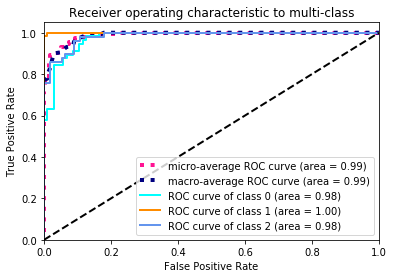

In [462]:
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### Next Step..... 
- Could we generalize the regression model as well?
- Use these parameters above and machine learning models (Decision Tree Regression) to predict the housing prices

Random Forest classifier performs the best overall 
It's performing questionably good - possibly there is data leakage:
   - gentrification is classified based on "income" and "rent"
   - demographic parameters like education level could highly be correlated to these
   - if number of cafes, bars etc.. actually correlates to the rent, it also could cause data leakage 